In [11]:
import pandas as pd

def load_btc_data(filepath: str, datetime_col='datetime', price_col='Close',
                  freq='D', split_date='2020-01-01'):
    """
    Load BTC OHLCV dataset and resample to daily frequency using last close price.
    Split into training and testing sets.

    Parameters:
    - filepath: Path to CSV file
    - datetime_col: Name of datetime column
    - price_col: Price column to use for strategy
    - freq: Resampling frequency (default 'D' = daily)
    - split_date: Cut-off date to split training/testing

    Returns:
    - train_df, test_df: DataFrames with Close prices
    """
    df = pd.read_csv(filepath, low_memory=False)
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.set_index(datetime_col).sort_index()
    
    df_resampled = df[[price_col]].resample(freq).last().dropna()
    df_resampled.rename(columns={price_col: 'Close'}, inplace=True)
    
    train_df = df_resampled[df_resampled.index < split_date].copy()
    test_df = df_resampled[df_resampled.index >= split_date].copy()
    
    return train_df, test_df


In [12]:
import numpy as np

def compute_ema_signal(df, fast_window, slow_window):
    """
    Generate EMA crossover signal: +1 (buy), -1 (sell), 0 (hold)
    """
    ema_fast = df['Close'].ewm(span=fast_window, adjust=False).mean()
    ema_slow = df['Close'].ewm(span=slow_window, adjust=False).mean()
    signal = np.where(ema_fast > ema_slow, 1, np.where(ema_fast < ema_slow, -1, 0))
    return pd.Series(signal, index=df.index)

def compute_rsi_signal(df, window, threshold):
    """
    Generate RSI-based signal: +1 (oversold), -1 (overbought), 0 (neutral)
    """
    delta = df['Close'].diff()
    up = delta.clip(lower=0).rolling(window=window).mean()
    down = -delta.clip(upper=0).rolling(window=window).mean()
    rs = up / (down + 1e-6)
    rsi = 100 - (100 / (1 + rs))

    signal = np.where(rsi < (100 - threshold), 1, np.where(rsi > threshold, -1, 0))
    return pd.Series(signal, index=df.index)

def compute_bb_signal(df, window, sigma):
    """
    Generate Bollinger Band signal: +1 (below lower band), -1 (above upper band), 0 (inside)
    """
    ma = df['Close'].rolling(window=window).mean()
    std = df['Close'].rolling(window=window).std()
    upper = ma + sigma * std
    lower = ma - sigma * std

    signal = np.where(df['Close'] > upper, -1, np.where(df['Close'] < lower, 1, 0))
    return pd.Series(signal, index=df.index)


In [13]:
def composite_strategy_signal(df, params):
    """
    Combine signals from EMA, RSI, BB using weighted average and threshold.

    Params:
    - params: [d1, d2, d3, rsi_thresh, d4, sigma, w1, w2, w3, decision_thresh]
    Returns:
    - Series of final trading signal (+1/-1/0)
    """
    d1, d2, d3, rsi_thresh, d4, sigma, w1, w2, w3, threshold = params
    s1 = compute_ema_signal(df, int(d1), int(d2))
    s2 = compute_rsi_signal(df, int(d3), rsi_thresh)
    s3 = compute_bb_signal(df, int(d4), sigma)

    weighted_sum = (w1 * s1 + w2 * s2 + w3 * s3) / (w1 + w2 + w3 + 1e-8)
    final_signal = np.where(weighted_sum > threshold, 1, np.where(weighted_sum < -threshold, -1, 0))
    return pd.Series(final_signal, index=df.index)


In [14]:
def backtest_with_fee(df, params, initial_cash=1000, fee_rate=0.03):
    """
    Simulate trading with fee, switching between cash and BTC only.
    
    Returns:
    - df with equity curve
    - final portfolio value (fitness score)
    """
    df = df.copy()
    df['Signal'] = composite_strategy_signal(df, params)
    
    cash = initial_cash
    btc = 0.0
    equity_list = []
    state = 'cash'

    for i in range(1, len(df)):
        price = df['Close'].iloc[i]
        signal = df['Signal'].iloc[i]

        if state == 'cash' and signal == 1:
            btc = (cash * (1 - fee_rate)) / price
            cash = 0.0
            state = 'btc'
        elif state == 'btc' and signal == -1:
            cash = btc * price * (1 - fee_rate)
            btc = 0.0
            state = 'cash'
        
        equity = cash if state == 'cash' else btc * price
        equity_list.append(equity)

    # final forced liquidation if in BTC
    if state == 'btc':
        final_price = df['Close'].iloc[-1]
        cash = btc * final_price * (1 - fee_rate)
        btc = 0.0
        equity = cash
    else:
        equity = cash

    df = df.iloc[1:]
    df['Equity'] = equity_list
    return df, equity


In [15]:
def fitness_function(params, df):
    """
    Evaluate final capital after backtesting using given parameters.
    """
    _, final_equity = backtest_with_fee(df, params)
    return final_equity


In [16]:
def whale_optimization(fitness_func, data, bounds, num_whales=10, max_iter=30):
    dim = len(bounds)
    whales = np.random.rand(num_whales, dim)
    for i in range(dim):
        whales[:, i] = bounds[i][0] + whales[:, i] * (bounds[i][1] - bounds[i][0])
    fitness = np.array([fitness_func(w, data) for w in whales])
    best_idx = np.argmax(fitness)
    best_whale, best_fitness = whales[best_idx].copy(), fitness[best_idx]
    a_linear = lambda t: 2 - 2 * (t / max_iter)
    for t in range(max_iter):
        a = a_linear(t)
        for i in range(num_whales):
            A = 2 * a * np.random.rand() - a
            C = 2 * np.random.rand()
            p = np.random.rand()
            if p < 0.5:
                if abs(A) < 1:
                    D = abs(C * best_whale - whales[i])
                    whales[i] = best_whale - A * D
                else:
                    rand_idx = np.random.randint(num_whales)
                    D = abs(C * whales[rand_idx] - whales[i])
                    whales[i] = whales[rand_idx] - A * D
            else:
                D = abs(best_whale - whales[i])
                l = np.random.uniform(-1, 1)
                whales[i] = D * np.exp(0.5 * l) * np.cos(2 * np.pi * l) + best_whale
            whales[i] = np.clip(whales[i], [b[0] for b in bounds], [b[1] for b in bounds])
        fitness = np.array([fitness_func(w, data) for w in whales])
        best_idx = np.argmax(fitness)
        if fitness[best_idx] > best_fitness:
            best_whale, best_fitness = whales[best_idx].copy(), fitness[best_idx]
    return best_whale, best_fitness


In [17]:
train_df,test_df=load_btc_data(filepath="D:/DATA/AI Data/archive/btcusd_1-min_data.csv")

# 参数范围：10维
bounds = [
    (5, 30),     # d1: EMA fast
    (20, 90),    # d2: EMA slow
    (7, 28),     # d3: RSI window
    (60, 80),    # RSI threshold
    (10, 50),    # BB window
    (1.5, 3.0),  # BB std
    (0.0, 1.0),  # w1
    (0.0, 1.0),  # w2
    (0.0, 1.0),  # w3
    (0.2, 0.7)   # decision threshold
]

# 运行优化器
best_params, best_score = whale_optimization(
    fitness_func=fitness_function,
    data=train_df,
    bounds=bounds,
    num_whales=20,
    max_iter=50
)

# 在测试集上评估最优参数
test_result, test_equity = backtest_with_fee(test_df, best_params)


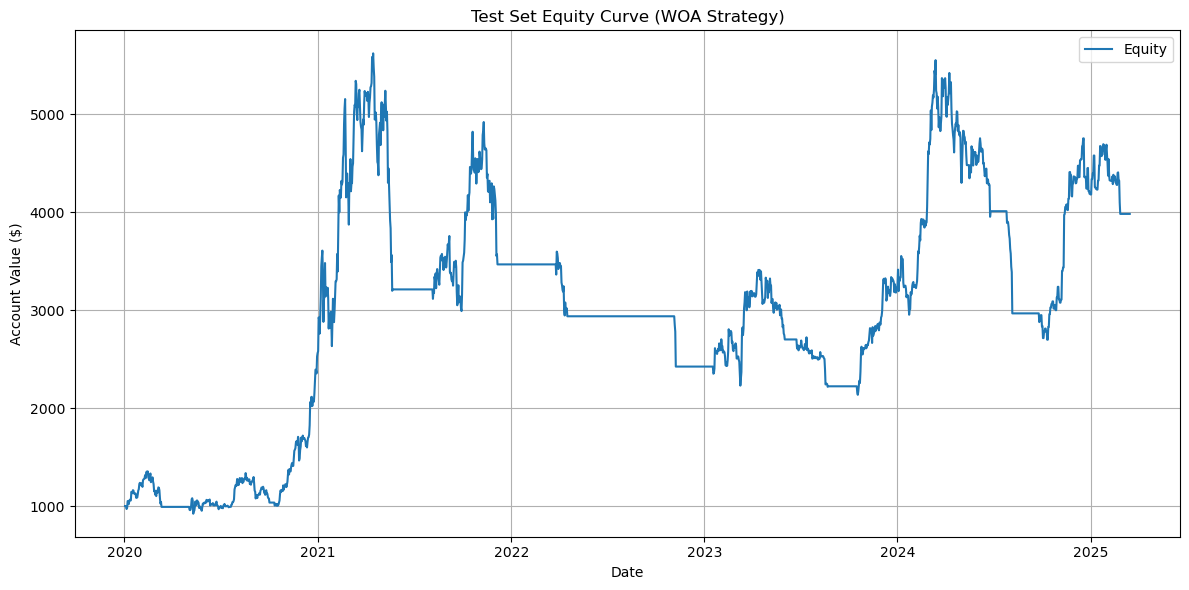

In [18]:
import matplotlib.pyplot as plt

def plot_equity_curve(result_df, title="Equity Curve"):
    plt.figure(figsize=(12, 6))
    plt.plot(result_df.index, result_df['Equity'], label="Equity")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Account Value ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_equity_curve(test_result, title="Test Set Equity Curve (WOA Strategy)")


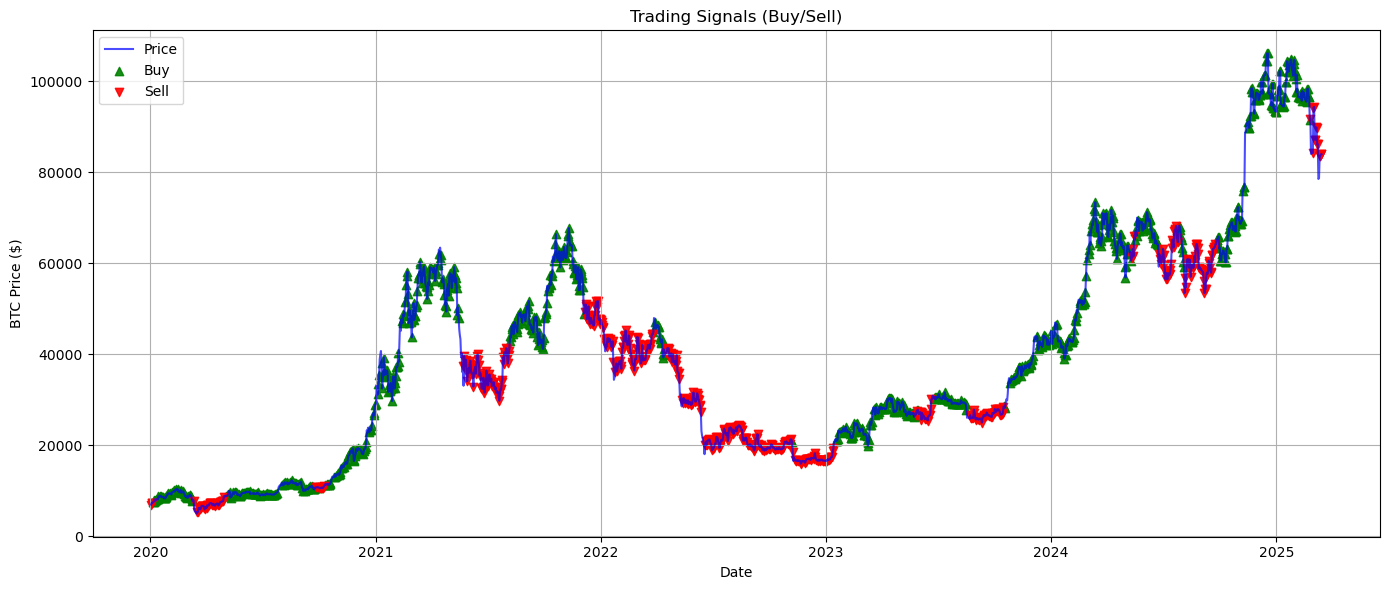

In [19]:
def plot_signals(result_df):
    buy_signals = result_df[result_df['Signal'] == 1]
    sell_signals = result_df[result_df['Signal'] == -1]

    plt.figure(figsize=(14, 6))
    plt.plot(result_df.index, result_df['Close'], label='Price', color='blue', alpha=0.7)
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy', alpha=0.9)
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell', alpha=0.9)
    plt.title("Trading Signals (Buy/Sell)")
    plt.xlabel("Date")
    plt.ylabel("BTC Price ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_signals(test_result)


In [20]:
import numpy as np

def grey_wolf_optimizer(fitness_func, data, bounds, num_wolves=10, max_iter=30):
    """
    Grey Wolf Optimizer (GWO) for continuous parameter tuning.
    """
    dim = len(bounds)
    wolves = np.random.rand(num_wolves, dim)
    for i in range(dim):
        wolves[:, i] = bounds[i][0] + wolves[:, i] * (bounds[i][1] - bounds[i][0])

    fitness = np.array([fitness_func(w, data) for w in wolves])
    alpha, beta, delta = wolves[np.argsort(-fitness)[:3]]

    for t in range(max_iter):
        a = 2 - t * (2 / max_iter)
        for i in range(num_wolves):
            X = wolves[i]
            A1, C1 = 2 * a * np.random.rand(dim) - a, 2 * np.random.rand(dim)
            A2, C2 = 2 * a * np.random.rand(dim) - a, 2 * np.random.rand(dim)
            A3, C3 = 2 * a * np.random.rand(dim) - a, 2 * np.random.rand(dim)

            D_alpha = abs(C1 * alpha - X)
            D_beta = abs(C2 * beta - X)
            D_delta = abs(C3 * delta - X)

            X1 = alpha - A1 * D_alpha
            X2 = beta - A2 * D_beta
            X3 = delta - A3 * D_delta

            wolves[i] = (X1 + X2 + X3) / 3
            wolves[i] = np.clip(wolves[i], [b[0] for b in bounds], [b[1] for b in bounds])

        fitness = np.array([fitness_func(w, data) for w in wolves])
        sorted_idx = np.argsort(-fitness)
        alpha, beta, delta = wolves[sorted_idx[0]], wolves[sorted_idx[1]], wolves[sorted_idx[2]]

    return alpha, fitness[sorted_idx[0]]


In [21]:
def particle_swarm_optimizer(fitness_func, data, bounds, num_particles=10, max_iter=30, w=0.5, c1=1.5, c2=1.5):
    """
    Particle Swarm Optimization (PSO) for continuous parameter tuning.
    """
    dim = len(bounds)
    pos = np.random.rand(num_particles, dim)
    vel = np.zeros((num_particles, dim))
    for i in range(dim):
        pos[:, i] = bounds[i][0] + pos[:, i] * (bounds[i][1] - bounds[i][0])

    pbest = pos.copy()
    pbest_val = np.array([fitness_func(p, data) for p in pos])
    gbest = pbest[np.argmax(pbest_val)].copy()
    gbest_val = max(pbest_val)

    for t in range(max_iter):
        for i in range(num_particles):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            vel[i] = w * vel[i] + c1 * r1 * (pbest[i] - pos[i]) + c2 * r2 * (gbest - pos[i])
            pos[i] += vel[i]
            pos[i] = np.clip(pos[i], [b[0] for b in bounds], [b[1] for b in bounds])

            val = fitness_func(pos[i], data)
            if val > pbest_val[i]:
                pbest[i] = pos[i]
                pbest_val[i] = val
                if val > gbest_val:
                    gbest = pos[i]
                    gbest_val = val

    return gbest, gbest_val


In [22]:
best_gwo_params, best_gwo_score = grey_wolf_optimizer(
    fitness_func=fitness_function,
    data=train_df,
    bounds=bounds,
    num_wolves=20,
    max_iter=50
)

# 🚀 运行 PSO
best_pso_params, best_pso_score = particle_swarm_optimizer(
    fitness_func=fitness_function,
    data=train_df,
    bounds=bounds,
    num_particles=20,
    max_iter=50
)

In [24]:
test_result1, test_equity1 = backtest_with_fee(test_df, best_gwo_params)
test_result2, test_equity2 = backtest_with_fee(test_df, best_pso_params)

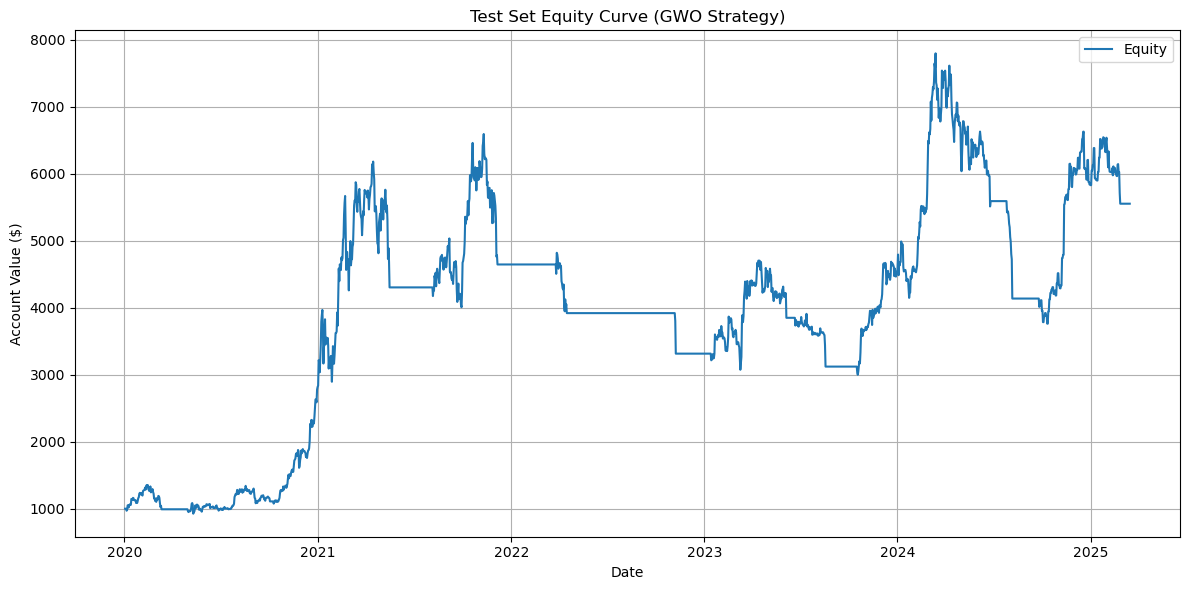

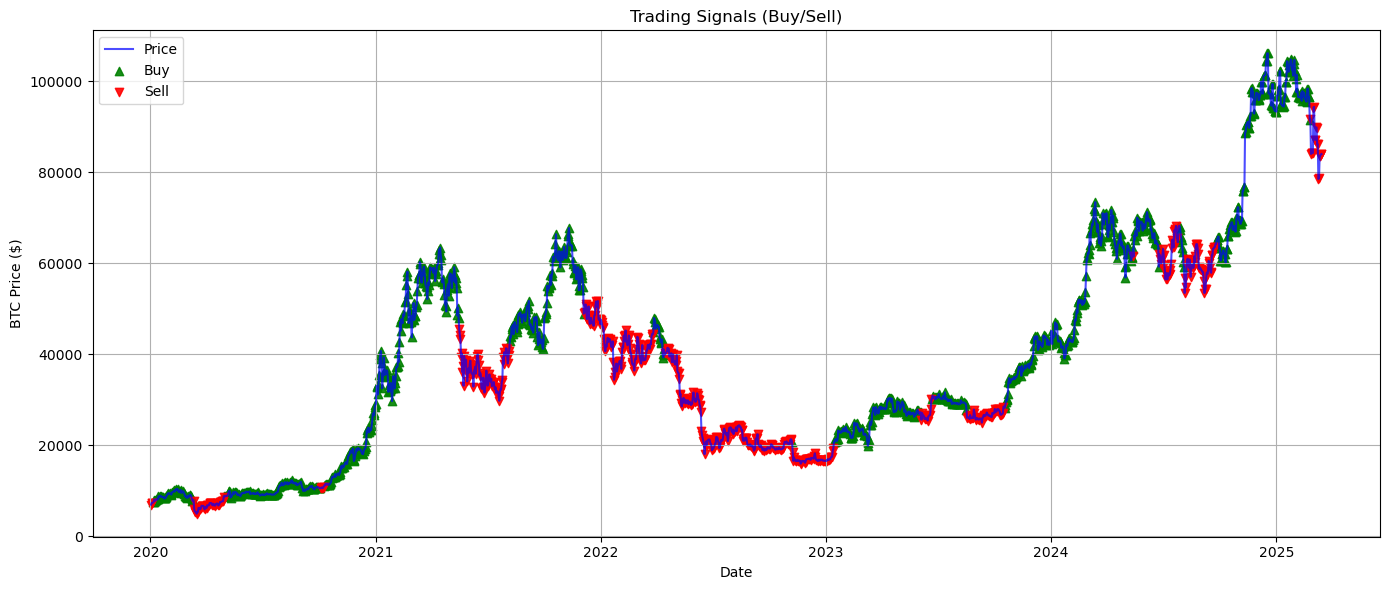

In [25]:
import matplotlib.pyplot as plt

def plot_equity_curve(result_df, title="Equity Curve"):
    plt.figure(figsize=(12, 6))
    plt.plot(result_df.index, result_df['Equity'], label="Equity")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Account Value ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_equity_curve(test_result1, title="Test Set Equity Curve (GWO Strategy)")

def plot_signals(result_df):
    buy_signals = result_df[result_df['Signal'] == 1]
    sell_signals = result_df[result_df['Signal'] == -1]

    plt.figure(figsize=(14, 6))
    plt.plot(result_df.index, result_df['Close'], label='Price', color='blue', alpha=0.7)
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy', alpha=0.9)
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell', alpha=0.9)
    plt.title("Trading Signals (Buy/Sell)")
    plt.xlabel("Date")
    plt.ylabel("BTC Price ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_signals(test_result2)


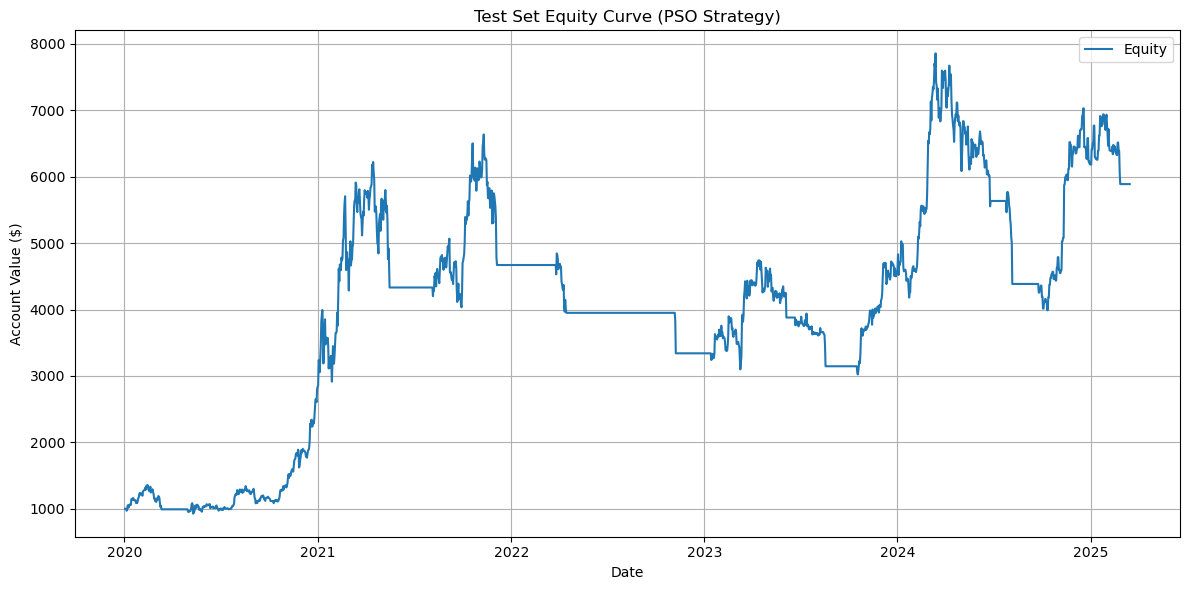

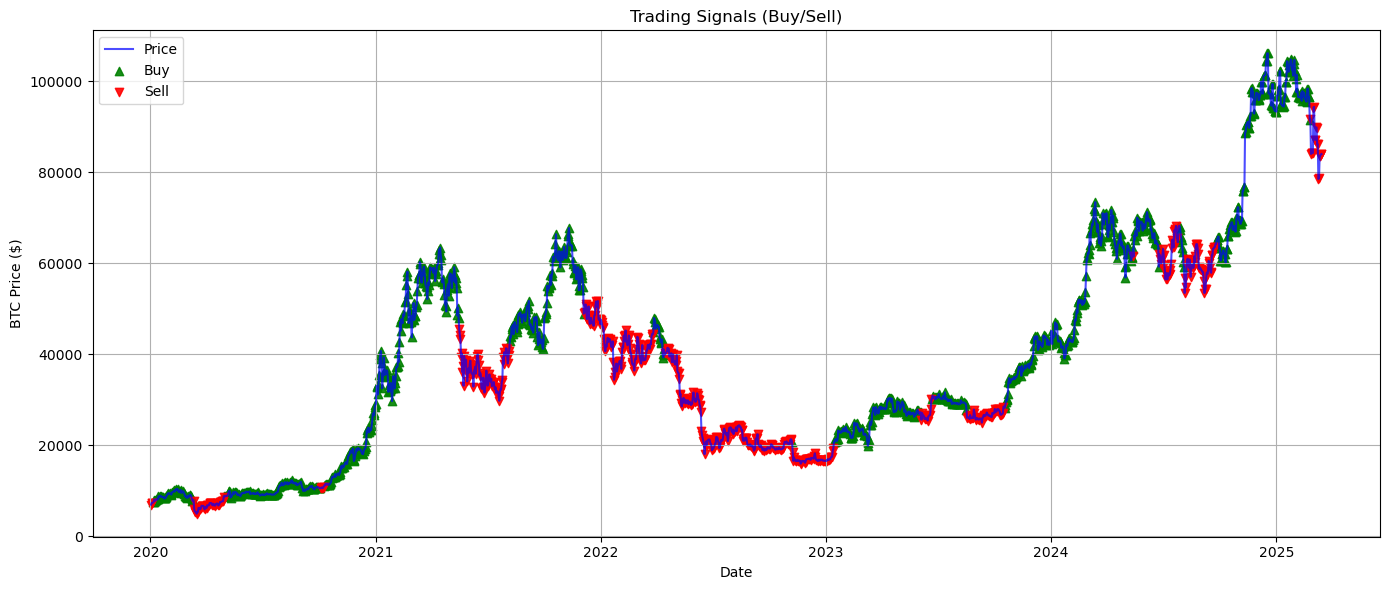

In [27]:
import matplotlib.pyplot as plt

def plot_equity_curve(result_df, title="Equity Curve"):
    plt.figure(figsize=(12, 6))
    plt.plot(result_df.index, result_df['Equity'], label="Equity")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Account Value ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_equity_curve(test_result2, title="Test Set Equity Curve (PSO Strategy)")

def plot_signals(result_df):
    buy_signals = result_df[result_df['Signal'] == 1]
    sell_signals = result_df[result_df['Signal'] == -1]

    plt.figure(figsize=(14, 6))
    plt.plot(result_df.index, result_df['Close'], label='Price', color='blue', alpha=0.7)
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy', alpha=0.9)
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell', alpha=0.9)
    plt.title("Trading Signals (Buy/Sell)")
    plt.xlabel("Date")
    plt.ylabel("BTC Price ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_signals(test_result2)